In [68]:
#### Preamble ####
# Purpose: Model the data to predict BTC/USDT's moving direction
# Author: Jiazhou(Justin) Bi
# Date: 16 Nov 2024
# Contact: justin.bi@mail.utoronto.ca
# License: None
# Pre-requisites: see requirements.txt
# Any other information needed? None

# Loading the Test Data

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.utils import to_categorical, plot_model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, Dropout, LSTM
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
import joblib
import xgboost as xgb
#from sklearn.model_selection import GridSearchCV

df_1m = pd.read_parquet('../data/03-lagged_differences_data/lagged_differences_data_1m.parquet')
df_1h = pd.read_parquet('../data/03-lagged_differences_data/lagged_differences_data_1h.parquet')
df_1d = pd.read_parquet('../data/03-lagged_differences_data/lagged_differences_data_1d.parquet')
df_1m.head(10)
#data\03-lagged_differences_data\lagged_differences_data_1d.parquet

,open,high,low,close,volume,was_missing,direction_t-1,direction_t+1,open_diff,high_diff,low_diff,close_diff
0,4261.48,4261.48,4261.48,4261.48,0.000000,0,0,1,0.00,0.00,0.00,0.00
1,4280.56,4280.56,4280.56,4280.56,0.261074,0,1,-1,19.08,19.08,19.08,19.08
2,4261.48,4261.48,4261.48,4261.48,0.012008,0,-1,0,-19.08,-19.08,-19.08,-19.08
3,4261.48,4261.48,4261.48,4261.48,0.140796,0,0,0,0.00,0.00,0.00,0.00
4,4261.48,4261.48,4261.48,4261.48,0.000000,0,0,0,0.00,0.00,0.00,0.00
5,4261.48,4261.48,4261.48,4261.48,0.000000,0,0,0,0.00,0.00,0.00,0.00
6,4261.48,4261.48,4261.48,4261.48,0.000000,0,0,0,0.00,0.00,0.00,0.00
7,4261.48,4261.48,4261.48,4261.48,0.000000,0,0,0,0.00,0.00,0.00,0.00
8,4261.48,4261.48,4261.48,4261.48,0.000000,0,0,0,0.00,0.00,0.00,0.00
9,4261.48,4261.48,4261.48,4261.48,0.000000,0,0,0,0.00,0.00,0.00,0.00


# RNN

## RNN for direction prediction

### 1-minute interval direction prediction

c:\Users\melty\anaconda3\envs\ml\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
95325/95325 ━━━━━━━━━━━━━━━━━━━━ 349s 4ms/step - accuracy: 0.4609 - loss: 0.8356 - val_accuracy: 0.4160 - val_loss: 0.9763
Epoch 2/20
95325/95325 ━━━━━━━━━━━━━━━━━━━━ 342s 4ms/step - accuracy: 0.4567 - loss: 0.8035 - val_accuracy: 0.3868 - val_loss: 1.0050
Epoch 3/20
95325/95325 ━━━━━━━━━━━━━━━━━━━━ 337s 4ms/step - accuracy: 0.4607 - loss: 0.7964 - val_accuracy: 0.4229 - val_loss: 0.9654
Epoch 4/20
95325/95325 ━━━━━━━━━━━━━━━━━━━━ 370s 4ms/step - accuracy: 0.4610 - loss: 0.7979 - val_accuracy: 0.4545 - val_loss: 0.9007
Epoch 5/20
95325/95325 ━━━━━━━━━━━━━━━━━━━━ 364s 4ms/step - accuracy: 0.4626 - loss: 0.7947 - val_accuracy: 0.4100 - val_loss: 0.9565
Epoch 6/20
95325/95325 ━━━━━━━━━━━━━━━━━━━━ 367s 4ms/step - accuracy: 0.4634 - loss: 0.7929 - val_accuracy: 0.4562 - val_loss: 0.9140
Epoch 7/20
95325/95325 ━━━━━━━━━━━━━━━━━━━━ 378s 4ms/step - accuracy: 0.4642 - loss: 0.7892 - val_accuracy: 0.4378 - val_loss: 0.9520
Epoch 8/20
95325/95325 ━━━━━━━━━━━━━━━━━━━━ 347s 4ms/step - ac

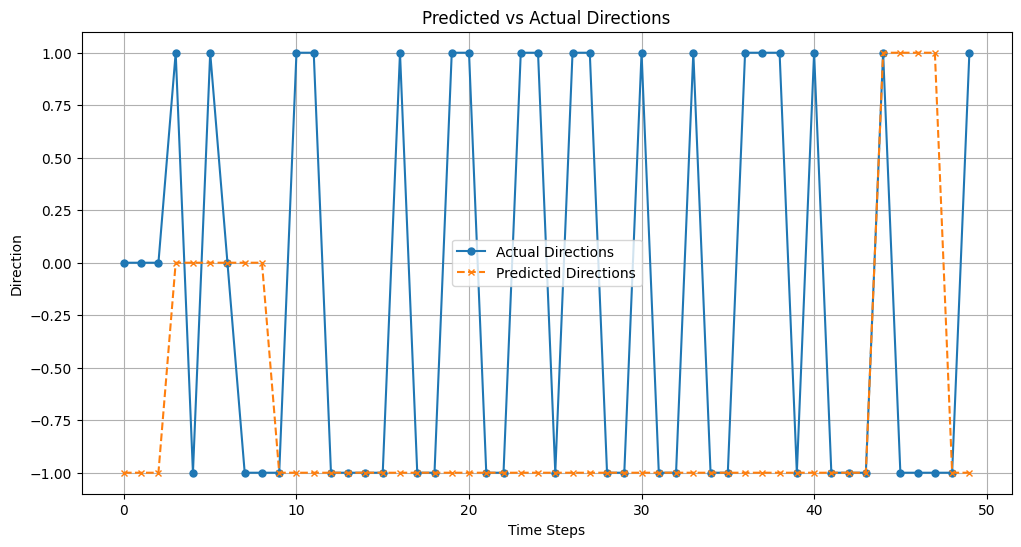

Confusion Matrix:
[[199763  68652  95659]
 [ 13680  19360    955]
 [199968  67630  96933]]
Classification Report:
              precision    recall  f1-score   support

          -1       0.48      0.55      0.51    364074
           0       0.12      0.57      0.20     33995
           1       0.50      0.27      0.35    364531

    accuracy                           0.41    762600
   macro avg       0.37      0.46      0.36    762600
weighted avg       0.48      0.41      0.42    762600



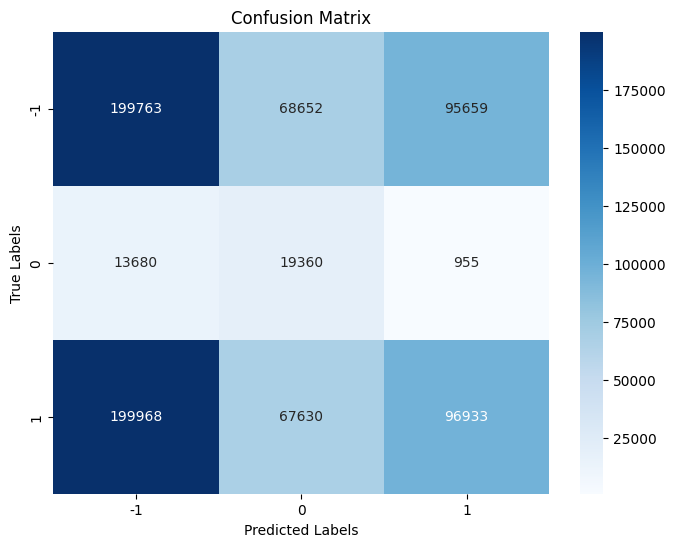

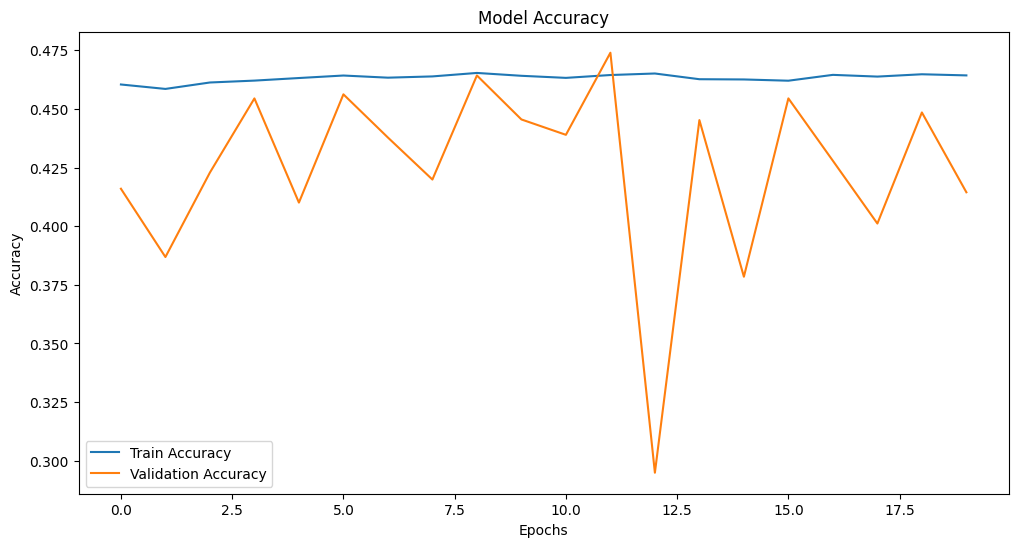

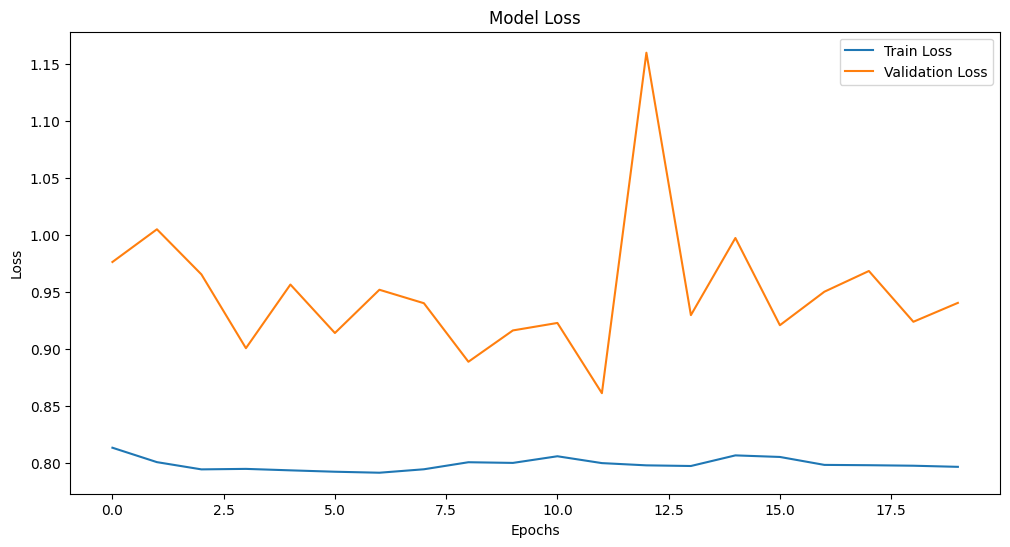

In [74]:
# Define features and target
features = ['open_diff', 'high_diff', 'low_diff', 'close_diff', 'volume', 'was_missing', 'direction_t-1']
target = 'direction_t+1'
X = df_1m[features]
y = df_1m[target]

# Normalize features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# One-hot encode the target variable (-1, 0, 1 -> 0, 1, 2)
y_encoded = to_categorical(y.map({-1: 0, 0: 1, 1: 2}))

# Function to create sequences
def create_sequences(X, y, time_steps=10):
    X_seq, y_seq = [], []
    for i in range(len(X) - time_steps):
        X_seq.append(X[i:i+time_steps])
        y_seq.append(y[i+time_steps])
    return np.array(X_seq), np.array(y_seq)

# Create sequences
time_steps = 10
X_seq, y_seq = create_sequences(X_scaled, y_encoded, time_steps=time_steps)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.array([0, 1, 2]), y=y.map({-1: 0, 0: 1, 1: 2}))
class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Define the RNN model
model = Sequential([
    SimpleRNN(128, activation='relu', input_shape=(time_steps, X_seq.shape[2]), return_sequences=True),
    Dropout(0.3),
    SimpleRNN(64, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(3, activation='softmax')  # 3 classes for multi-class classification
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model with class weights
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test),
    class_weight=class_weights_dict,
    verbose=1
)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

# Predict the directions
y_pred_prob = model.predict(X_test)
y_pred_classes = np.argmax(y_pred_prob, axis=1)  # Convert probabilities to class indices
y_test_classes = np.argmax(y_test, axis=1)  # Convert one-hot to class indices

# Map back to original labels (-1, 0, 1)
map_back = {0: -1, 1: 0, 2: 1}
y_pred_final = np.vectorize(map_back.get)(y_pred_classes)
y_test_final = np.vectorize(map_back.get)(y_test_classes)

# Visualize Predictions vs Actuals
plt.figure(figsize=(12, 6))
plt.plot(range(50), y_test_final[:50], label='Actual Directions', marker='o', linestyle='-', markersize=5)
plt.plot(range(50), y_pred_final[:50], label='Predicted Directions', marker='x', linestyle='--', markersize=5)
plt.title('Predicted vs Actual Directions')
plt.xlabel('Time Steps')
plt.ylabel('Direction')
plt.legend()
plt.grid(True)
plt.show()

# Confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)
print("Confusion Matrix:")
print(cm)

# Classification report
print("Classification Report:")
print(classification_report(y_test_classes, y_pred_classes, target_names=["-1", "0", "1"]))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["-1", "0", "1"], yticklabels=["-1", "0", "1"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Visualize training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Save the model
model.save('../model/RNN/Directional_Classification_Model/rnn_direction_model_1m.keras')

### 1-hour interval direction prediction

Epoch 1/20


c:\Users\melty\anaconda3\envs\ml\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1589/1589 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5147 - loss: 0.6933 - val_accuracy: 0.5170 - val_loss: 0.6923
Epoch 2/20
1589/1589 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5271 - loss: 0.6912 - val_accuracy: 0.5170 - val_loss: 0.6924
Epoch 3/20
1589/1589 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.5214 - loss: 0.6916 - val_accuracy: 0.5182 - val_loss: 0.6921
Epoch 4/20
1589/1589 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5240 - loss: 0.6914 - val_accuracy: 0.5170 - val_loss: 0.6923
Epoch 5/20
1589/1589 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5235 - loss: 0.6911 - val_accuracy: 0.5170 - val_loss: 0.6924
Epoch 6/20
1589/1589 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5236 - loss: 0.6909 - val_accuracy: 0.5170 - val_loss: 0.6927
Epoch 7/20
1589/1589 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5253 - loss: 0.6913 - val_accuracy: 0.5169 - val_loss: 0.6921
Epoch 8/20
1589/1589 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.5221 - loss: 0.6913 - val_accurac

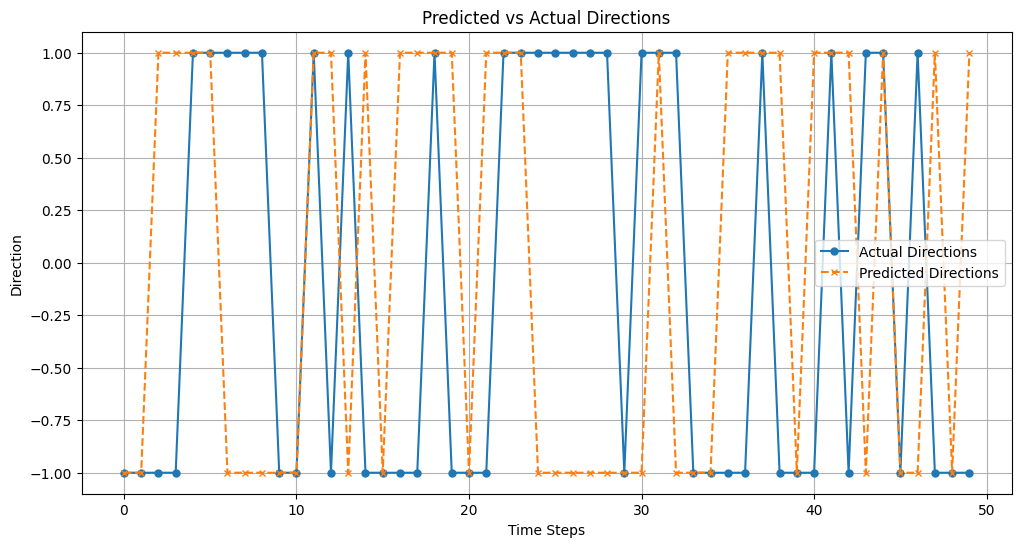

Confusion Matrix:
[[3285 2915]
 [3223 3285]]
Classification Report:
              precision    recall  f1-score   support

          -1       0.50      0.53      0.52      6200
           1       0.53      0.50      0.52      6508

    accuracy                           0.52     12708
   macro avg       0.52      0.52      0.52     12708
weighted avg       0.52      0.52      0.52     12708



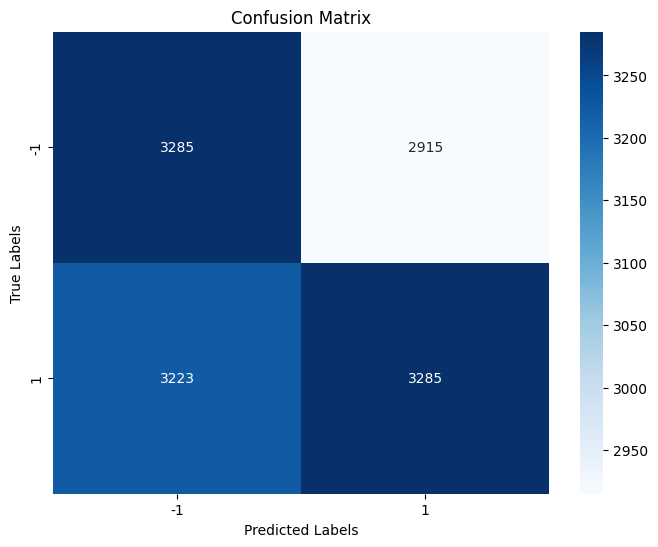

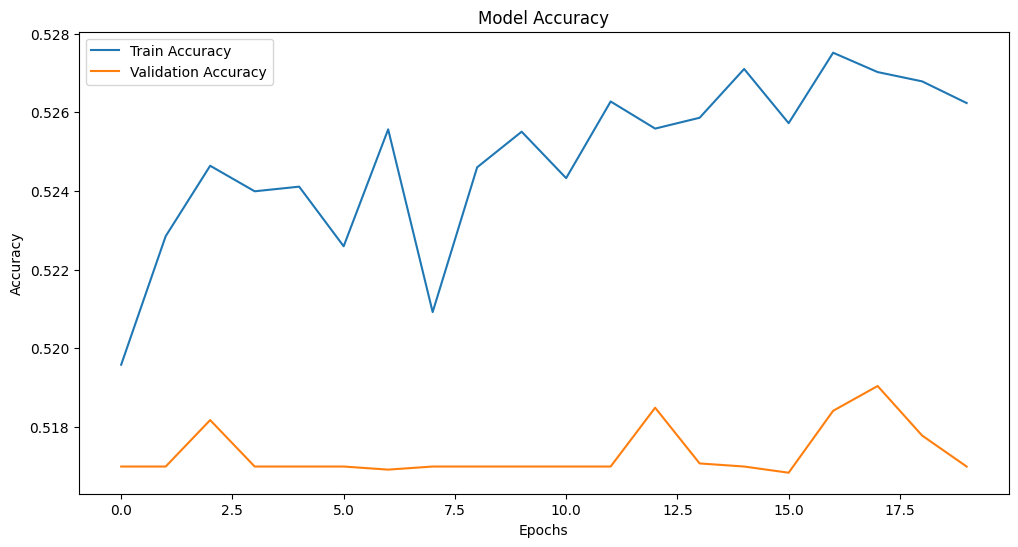

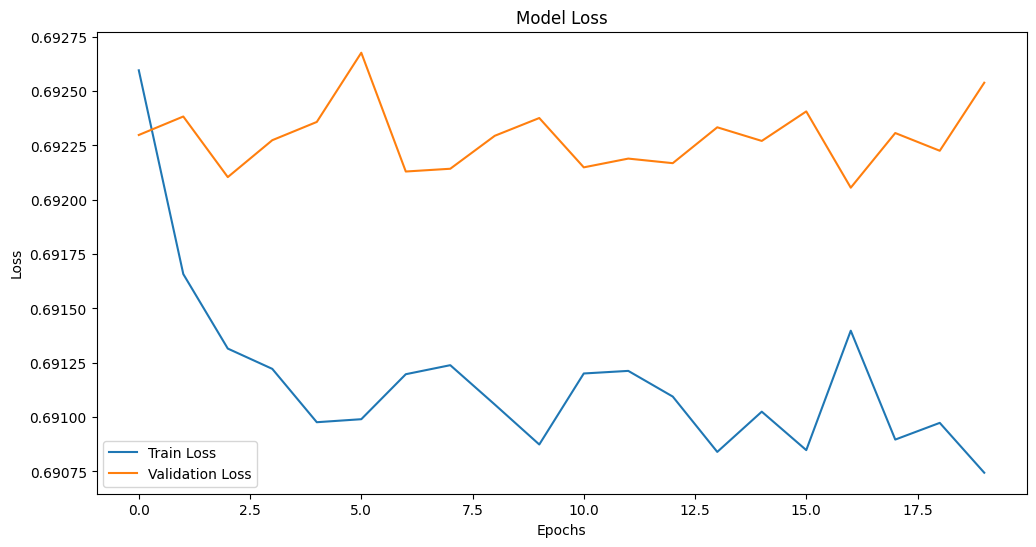

In [63]:
# Define features and target
features = ['open_diff', 'high_diff', 'low_diff', 'close_diff', 'volume', 'was_missing', 'direction_t-1']
target = 'direction_t+1'
X = df_1h[features]
y = df_1h[target]

# Normalize features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Map target to binary (optional)
y_binary = (y + 1) // 2  # Map -1 to 0, 1 stays as 1

# Function to create sequences
def create_sequences(X, y, time_steps=10):
    X_seq, y_seq = [], []
    for i in range(len(X) - time_steps):
        X_seq.append(X[i:i+time_steps])
        y_seq.append(y[i+time_steps])
    return np.array(X_seq), np.array(y_seq)

# Create sequences
time_steps = 10
X_seq, y_seq = create_sequences(X_scaled, y_binary.values, time_steps=time_steps)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)

# Define the RNN model
model = Sequential([
    SimpleRNN(128, activation='relu', input_shape=(time_steps, X_seq.shape[2])),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Sigmoid for binary classification
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

# Predict and map back to original labels
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)  # Binary predictions (0 or 1)
y_pred_final = (y_pred_classes * 2) - 1  # Map 0 back to -1, keep 1 as 1
y_test_final = (y_test * 2) - 1 

# Visualize Predictions vs Actuals
plt.figure(figsize=(12, 6))
plt.plot(range(50), y_test_final[:50], label='Actual Directions', marker='o', linestyle='-', markersize=5)
plt.plot(range(50), y_pred_final[:50], label='Predicted Directions', marker='x', linestyle='--', markersize=5)
plt.title('Predicted vs Actual Directions')
plt.xlabel('Time Steps')
plt.ylabel('Direction')
plt.legend()
plt.grid(True)
plt.show()

# Confusion matrix
cm = confusion_matrix(y_test * 2 - 1, y_pred_final)  # Map y_test back to -1 and 1
print("Confusion Matrix:")
print(cm)

# Classification report
print("Classification Report:")
print(classification_report(y_test * 2 - 1, y_pred_final, target_names=["-1", "1"]))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["-1", "1"], yticklabels=["-1", "1"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Visualize training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Save the model
model.save('../model/RNN/Directional_Classification_Model/rnn_direction_model_1h.keras')

### 1-day interval direction prediction

Epoch 1/20


c:\Users\melty\anaconda3\envs\ml\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4909 - loss: 0.6996 - val_accuracy: 0.5170 - val_loss: 0.6922
Epoch 2/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5239 - loss: 0.6916 - val_accuracy: 0.5189 - val_loss: 0.6924
Epoch 3/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4996 - loss: 0.6949 - val_accuracy: 0.5208 - val_loss: 0.6922
Epoch 4/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5159 - loss: 0.6928 - val_accuracy: 0.5208 - val_loss: 0.6924
Epoch 5/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4768 - loss: 0.6956 - val_accuracy: 0.5189 - val_loss: 0.6917
Epoch 6/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4975 - loss: 0.6949 - val_accuracy: 0.5189 - val_loss: 0.6918
Epoch 7/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4911 - loss: 0.6938 - val_accuracy: 0.4981 - val_loss: 0.6931
Epoch 8/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5259 - loss: 0.6932 - val_accuracy: 0.5189 - val_loss: 0.6919
Epo

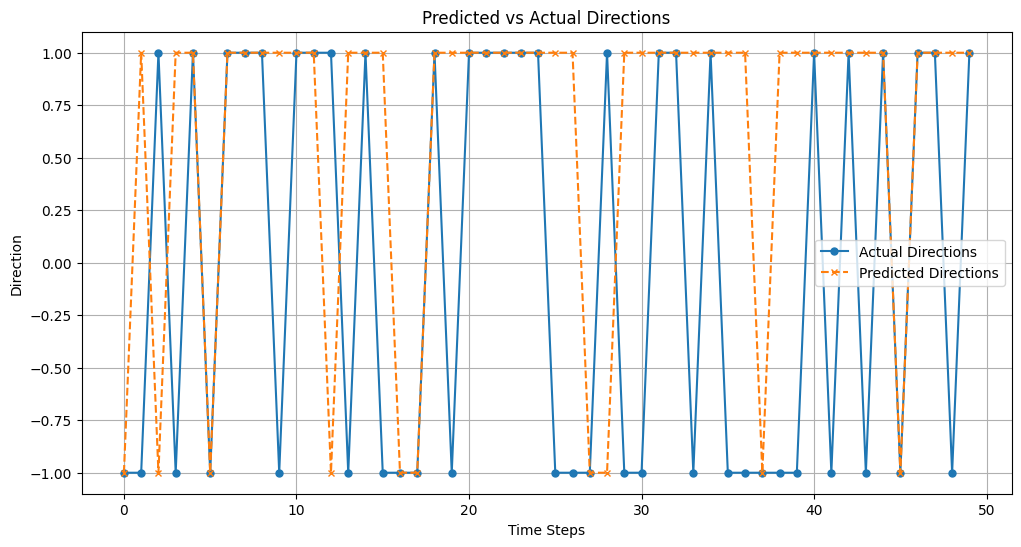

Confusion Matrix:
[[ 58 196]
 [ 56 218]]
Classification Report:
              precision    recall  f1-score   support

          -1       0.51      0.23      0.32       254
           1       0.53      0.80      0.63       274

    accuracy                           0.52       528
   macro avg       0.52      0.51      0.47       528
weighted avg       0.52      0.52      0.48       528



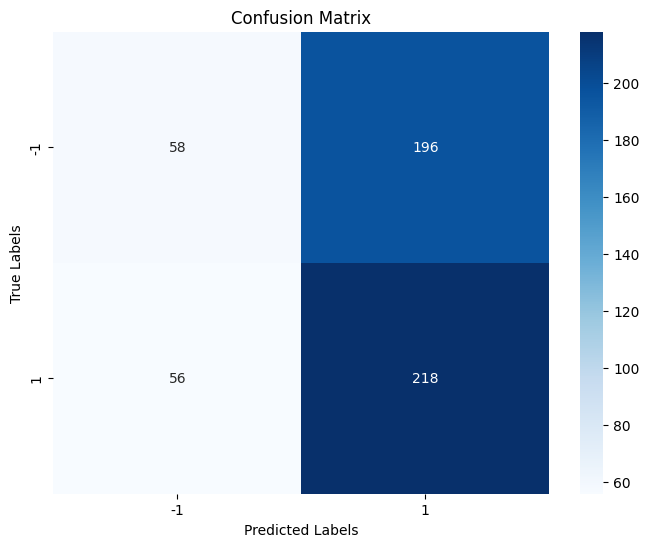

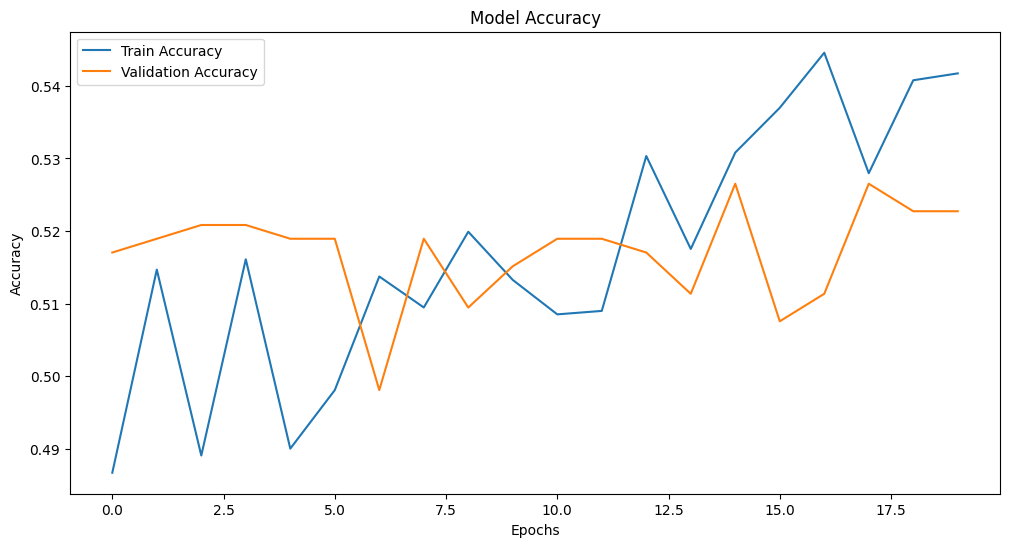

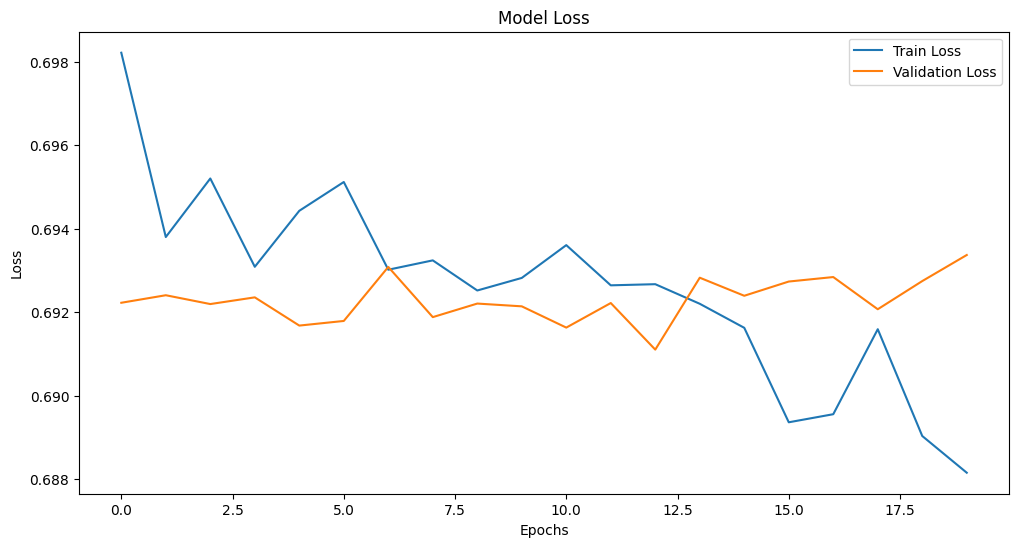

In [51]:
# Define features and target
features = ['open_diff', 'high_diff', 'low_diff', 'close_diff', 'volume', 'direction_t-1']
target = 'direction_t+1'
X = df_1d[features]
y = df_1d[target]

# Normalize features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Map target to binary (optional)
y_binary = (y + 1) // 2  # Map -1 to 0, 1 stays as 1

# Function to create sequences
def create_sequences(X, y, time_steps=10):
    X_seq, y_seq = [], []
    for i in range(len(X) - time_steps):
        X_seq.append(X[i:i+time_steps])
        y_seq.append(y[i+time_steps])
    return np.array(X_seq), np.array(y_seq)

# Create sequences
time_steps = 10
X_seq, y_seq = create_sequences(X_scaled, y_binary.values, time_steps=time_steps)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)

# Define the RNN model
model = Sequential([
    SimpleRNN(128, activation='relu', input_shape=(time_steps, X_seq.shape[2])),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Sigmoid for binary classification
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

# Predict and map back to original labels
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)  # Binary predictions (0 or 1)
y_pred_final = (y_pred_classes * 2) - 1  # Map 0 back to -1, keep 1 as 1
y_test_final = (y_test * 2) - 1 

# Visualize Predictions vs Actuals
plt.figure(figsize=(12, 6))
plt.plot(range(50), y_test_final[:50], label='Actual Directions', marker='o', linestyle='-', markersize=5)
plt.plot(range(50), y_pred_final[:50], label='Predicted Directions', marker='x', linestyle='--', markersize=5)
plt.title('Predicted vs Actual Directions')
plt.xlabel('Time Steps')
plt.ylabel('Direction')
plt.legend()
plt.grid(True)
plt.show()

# Confusion matrix
cm = confusion_matrix(y_test * 2 - 1, y_pred_final)  # Map y_test back to -1 and 1
print("Confusion Matrix:")
print(cm)

# Classification report
print("Classification Report:")
print(classification_report(y_test * 2 - 1, y_pred_final, target_names=["-1", "1"]))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["-1", "1"], yticklabels=["-1", "1"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Visualize training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Save the model
model.save('../model/RNN/Directional_Classification_Model/rnn_direction_model_1d.keras')

# LSTM

## LSTM Directional Models

### Prediction for 1-minute dataset

c:\Users\melty\anaconda3\envs\ml\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
95325/95325 ━━━━━━━━━━━━━━━━━━━━ 350s 4ms/step - accuracy: 0.0256 - loss: -12985158336512.0000 - val_accuracy: 0.0446 - val_loss: 0.1692
Epoch 2/20
95325/95325 ━━━━━━━━━━━━━━━━━━━━ 345s 4ms/step - accuracy: 0.0236 - loss: 0.0902 - val_accuracy: 0.0446 - val_loss: 0.0217
Epoch 3/20
95325/95325 ━━━━━━━━━━━━━━━━━━━━ 331s 3ms/step - accuracy: 0.0238 - loss: 0.0276 - val_accuracy: 0.0446 - val_loss: 0.0133
Epoch 4/20
95325/95325 ━━━━━━━━━━━━━━━━━━━━ 338s 4ms/step - accuracy: 0.0238 - loss: 0.0226 - val_accuracy: 0.0446 - val_loss: 0.0105
Epoch 5/20
95325/95325 ━━━━━━━━━━━━━━━━━━━━ 333s 3ms/step - accuracy: 0.0236 - loss: 0.0203 - val_accuracy: 0.0446 - val_loss: 0.0092
Epoch 6/20
95325/95325 ━━━━━━━━━━━━━━━━━━━━ 338s 4ms/step - accuracy: 0.0237 - loss: 0.0200 - val_accuracy: 0.0446 - val_loss: 0.0084
Epoch 7/20
95325/95325 ━━━━━━━━━━━━━━━━━━━━ 335s 4ms/step - accuracy: 0.0238 - loss: 0.0142 - val_accuracy: 0.0446 - val_loss: 0.0079
Epoch 8/20
95325/95325 ━━━━━━━━━━━━━━━━━━━━ 337s

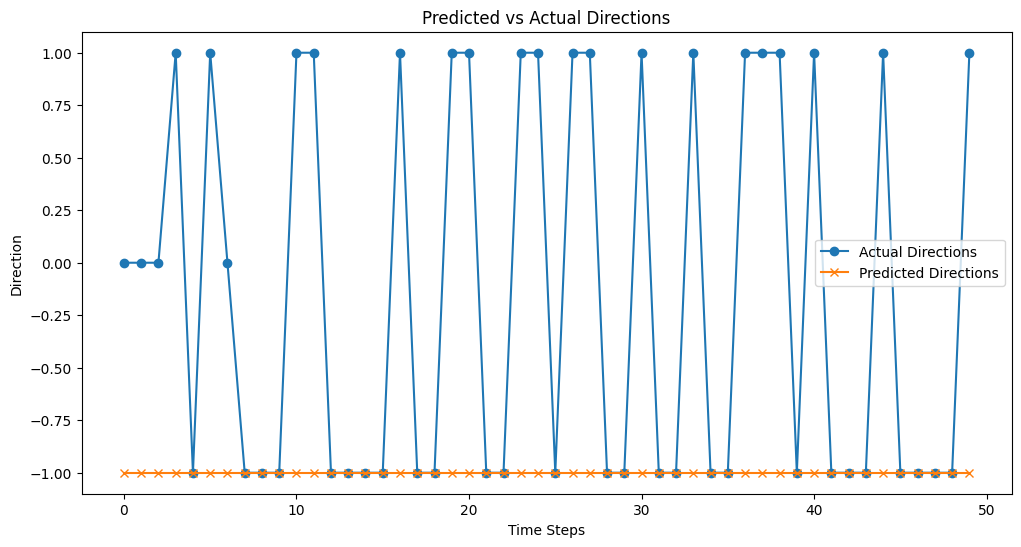

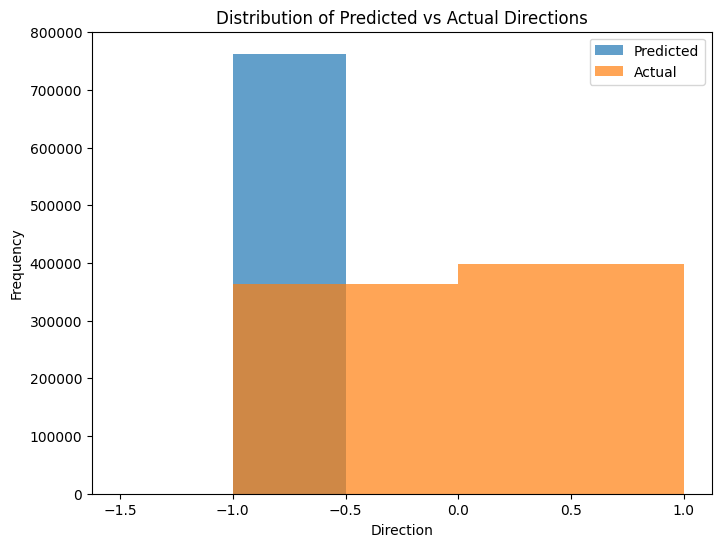

Confusion Matrix:
[[364074      0      0]
 [ 33995      0      0]
 [364531      0      0]]


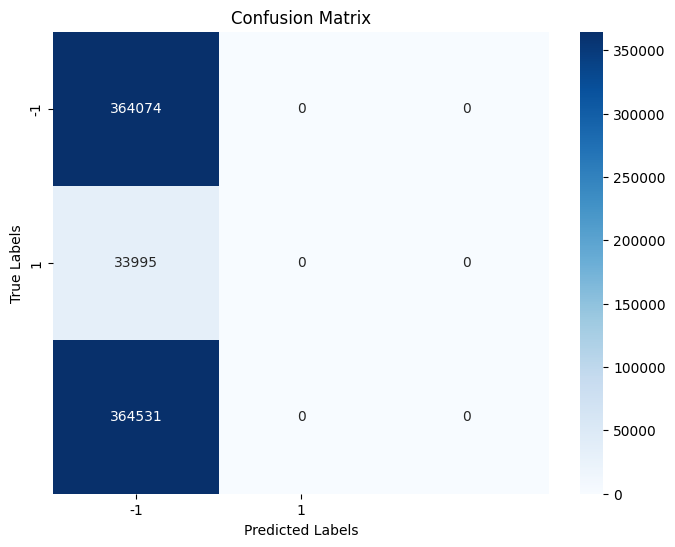

In [75]:
# Define features and target
features = ['open_diff', 'high_diff', 'low_diff', 'close_diff', 'volume', 'was_missing', 'direction_t-1']
target = 'direction_t+1'
X = df_1m[features]
y = df_1m[target]

# Normalize features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Function to create sequences
def create_sequences(X, y, time_steps=10):
    X_seq, y_seq = [], []
    for i in range(len(X) - time_steps):
        X_seq.append(X[i:i+time_steps])
        y_seq.append(y[i+time_steps])
    return np.array(X_seq), np.array(y_seq)

# Create sequences
time_steps = 10
X_seq, y_seq = create_sequences(X_scaled, y.values, time_steps=time_steps)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)

# Define the LSTM model
model = Sequential([
    LSTM(128, activation='relu', input_shape=(time_steps, X_seq.shape[2]), return_sequences=False),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Sigmoid for binary classification
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

# Predict the directions
y_pred_prob = model.predict(X_test)
y_pred_classes = np.where(y_pred_prob > 0.5, 1, -1)  # Convert probabilities to -1 or 1

# Visualize Predictions vs Actuals
plt.figure(figsize=(12, 6))
plt.plot(y_test[:50], label='Actual Directions', marker='o')
plt.plot(y_pred_classes[:50], label='Predicted Directions', marker='x')
plt.title('Predicted vs Actual Directions')
plt.xlabel('Time Steps')
plt.ylabel('Direction')
plt.legend()
plt.show()

# Visualize Prediction Distribution
plt.figure(figsize=(8, 6))
plt.hist(y_pred_classes, bins=2, alpha=0.7, label='Predicted')
plt.hist(y_test, bins=2, alpha=0.7, label='Actual')
plt.title('Distribution of Predicted vs Actual Directions')
plt.xlabel('Direction')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Display the confusion matrix numerically
print("Confusion Matrix:")
print(cm)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[-1, 1], yticklabels=[-1, 1])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


# Save the model
model.save('../model/LSTM/Directional_Classification_Model/lstm_direction_model_1m.keras')

### Prediction for 1-hour dataset

Epoch 1/20


c:\Users\melty\anaconda3\envs\ml\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1589/1589 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.0021 - loss: 0.2199 - val_accuracy: 0.0000e+00 - val_loss: 0.1122
Epoch 2/20
1589/1589 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.0000e+00 - loss: 0.1116 - val_accuracy: 0.0000e+00 - val_loss: 0.1136
Epoch 3/20
1589/1589 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.0000e+00 - loss: 0.0958 - val_accuracy: 0.0000e+00 - val_loss: 0.1165
Epoch 4/20
1589/1589 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.0000e+00 - loss: 0.0835 - val_accuracy: 0.0000e+00 - val_loss: 0.1010
Epoch 5/20
1589/1589 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 1.9132e-04 - loss: 0.0875 - val_accuracy: 0.0000e+00 - val_loss: 0.0967
Epoch 6/20
1589/1589 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 1.6764e-04 - loss: 0.0967 - val_accuracy: 0.0000e+00 - val_loss: 0.0935
Epoch 7/20
1589/1589 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 5.7836e-04 - loss: 0.1092 - val_accuracy: 0.0000e+00 - val_loss: 0.0933
Epoch 8/20
1589/1589 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/

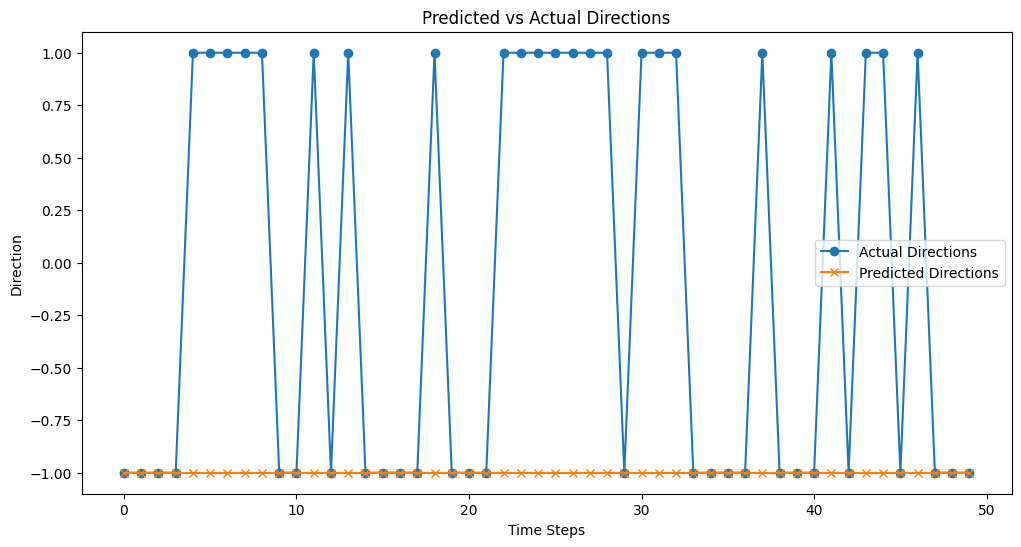

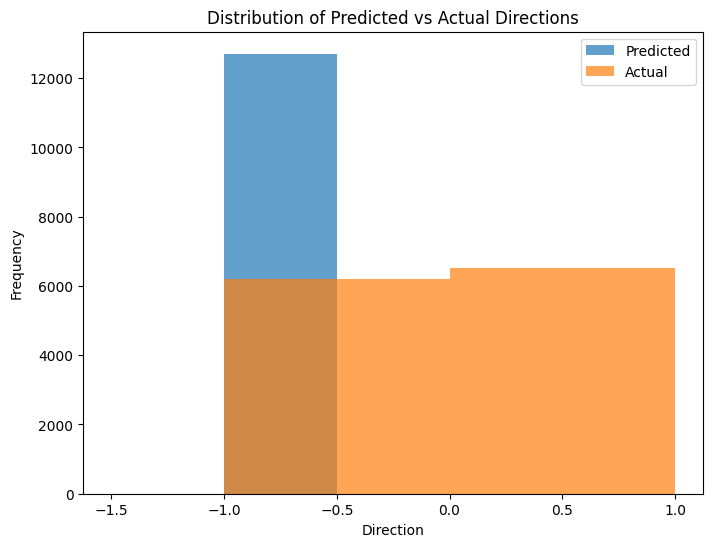

Confusion Matrix:
[[6200    0]
 [6508    0]]


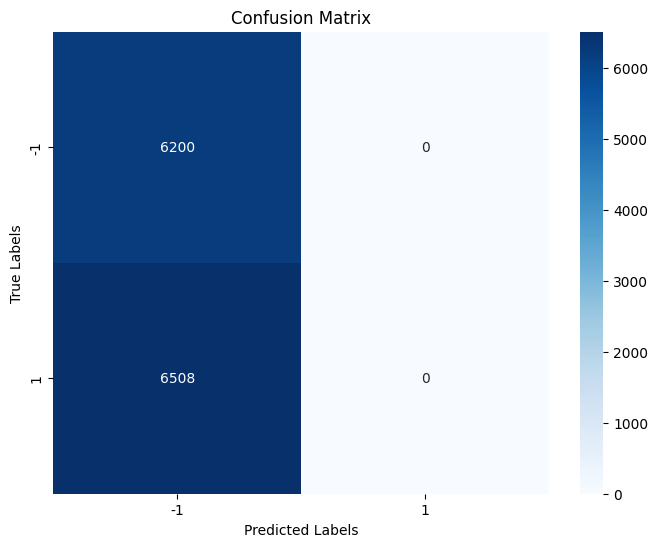

In [64]:
# Define features and target
features = ['open_diff', 'high_diff', 'low_diff', 'close_diff', 'volume', 'was_missing', 'direction_t-1']
target = 'direction_t+1'
X = df_1h[features]
y = df_1h[target]

# Normalize features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Function to create sequences
def create_sequences(X, y, time_steps=10):
    X_seq, y_seq = [], []
    for i in range(len(X) - time_steps):
        X_seq.append(X[i:i+time_steps])
        y_seq.append(y[i+time_steps])
    return np.array(X_seq), np.array(y_seq)

# Create sequences
time_steps = 10
X_seq, y_seq = create_sequences(X_scaled, y.values, time_steps=time_steps)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)

# Define the LSTM model
model = Sequential([
    LSTM(128, activation='relu', input_shape=(time_steps, X_seq.shape[2]), return_sequences=False),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Sigmoid for binary classification
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

# Predict the directions
y_pred_prob = model.predict(X_test)
y_pred_classes = np.where(y_pred_prob > 0.5, 1, -1)  # Convert probabilities to -1 or 1

# Visualize Predictions vs Actuals
plt.figure(figsize=(12, 6))
plt.plot(y_test[:50], label='Actual Directions', marker='o')
plt.plot(y_pred_classes[:50], label='Predicted Directions', marker='x')
plt.title('Predicted vs Actual Directions')
plt.xlabel('Time Steps')
plt.ylabel('Direction')
plt.legend()
plt.show()

# Visualize Prediction Distribution
plt.figure(figsize=(8, 6))
plt.hist(y_pred_classes, bins=2, alpha=0.7, label='Predicted')
plt.hist(y_test, bins=2, alpha=0.7, label='Actual')
plt.title('Distribution of Predicted vs Actual Directions')
plt.xlabel('Direction')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Display the confusion matrix numerically
print("Confusion Matrix:")
print(cm)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[-1, 1], yticklabels=[-1, 1])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


# Save the model
model.save('../model/LSTM/Directional_Classification_Model/lstm_direction_model_1h.keras')

### Prediction for 1-day dataset

Epoch 1/20


c:\Users\melty\anaconda3\envs\ml\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.1032 - loss: 0.6548 - val_accuracy: 0.0000e+00 - val_loss: 0.5286
Epoch 2/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00 - loss: 0.4779 - val_accuracy: 0.0000e+00 - val_loss: 0.2270
Epoch 3/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 0.1414 - val_accuracy: 0.0000e+00 - val_loss: 0.1925
Epoch 4/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00 - loss: 0.0845 - val_accuracy: 0.0000e+00 - val_loss: 0.1782
Epoch 5/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00 - loss: 0.2215 - val_accuracy: 0.0000e+00 - val_loss: 0.1814
Epoch 6/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 0.1175 - val_accuracy: 0.0000e+00 - val_loss: 0.2017
Epoch 7/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - loss: 0.1521 - val_accuracy: 0.0000e+00 - val_loss: 0.1924
Epoch 8/20
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.0000e+00 - lo

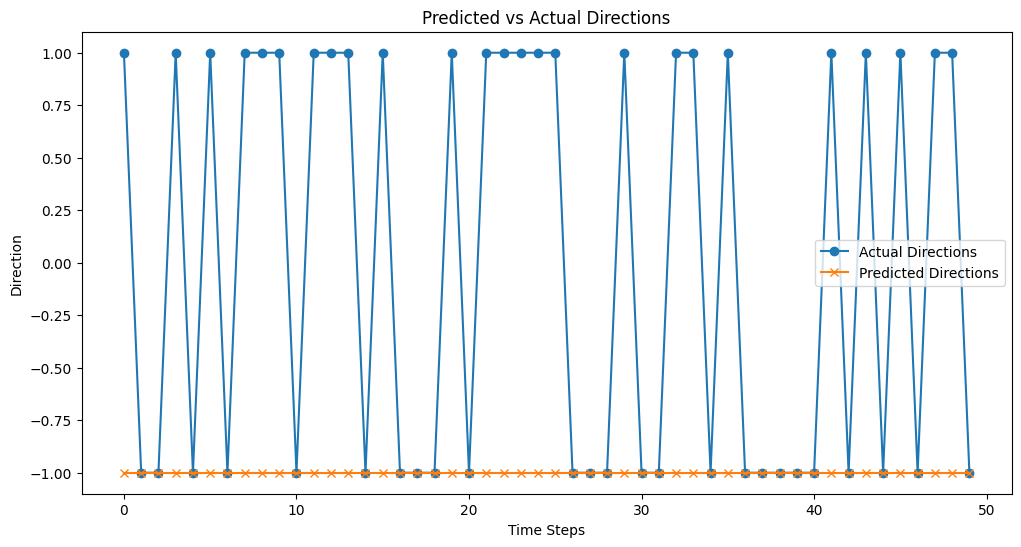

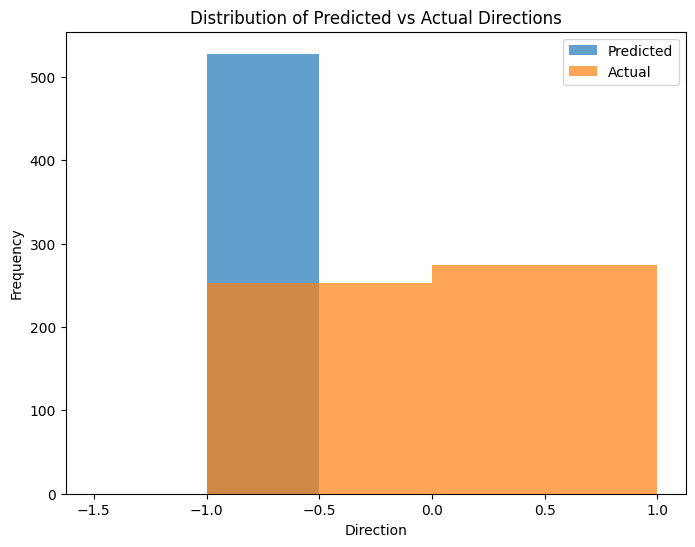

Confusion Matrix:
[[253   0]
 [275   0]]


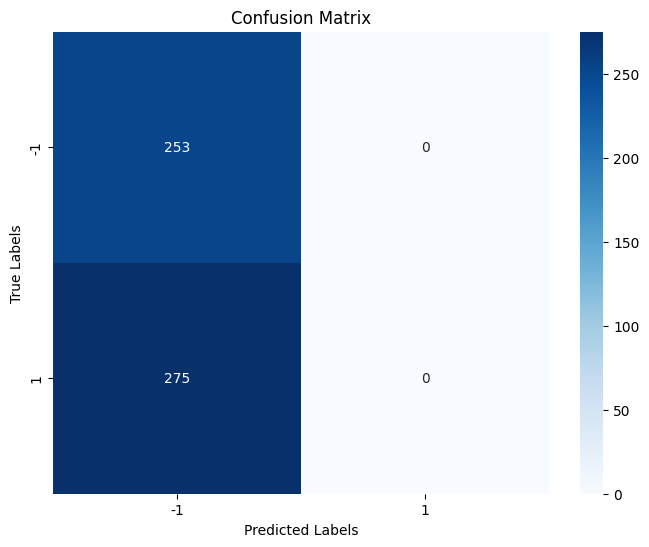

In [67]:
# Define features and target
features = ['open_diff', 'high_diff', 'low_diff', 'close_diff', 'volume', 'direction_t-1']
target = 'direction_t+1'
X = df_1d[features]
y = df_1d[target]

# Normalize features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Function to create sequences
def create_sequences(X, y, time_steps=10):
    X_seq, y_seq = [], []
    for i in range(len(X) - time_steps):
        X_seq.append(X[i:i+time_steps])
        y_seq.append(y[i+time_steps])
    return np.array(X_seq), np.array(y_seq)

# Create sequences
time_steps = 10
X_seq, y_seq = create_sequences(X_scaled, y.values, time_steps=time_steps)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)

# Define the LSTM model
model = Sequential([
    LSTM(128, activation='relu', input_shape=(time_steps, X_seq.shape[2]), return_sequences=False),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Sigmoid for binary classification
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test),
    verbose=1
)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

# Predict the directions
y_pred_prob = model.predict(X_test)
y_pred_classes = np.where(y_pred_prob > 0.5, 1, -1)  # Convert probabilities to -1 or 1

# Visualize Predictions vs Actuals
plt.figure(figsize=(12, 6))
plt.plot(y_test[:50], label='Actual Directions', marker='o')
plt.plot(y_pred_classes[:50], label='Predicted Directions', marker='x')
plt.title('Predicted vs Actual Directions')
plt.xlabel('Time Steps')
plt.ylabel('Direction')
plt.legend()
plt.show()

# Visualize Prediction Distribution
plt.figure(figsize=(8, 6))
plt.hist(y_pred_classes, bins=2, alpha=0.7, label='Predicted')
plt.hist(y_test, bins=2, alpha=0.7, label='Actual')
plt.title('Distribution of Predicted vs Actual Directions')
plt.xlabel('Direction')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Display the confusion matrix numerically
print("Confusion Matrix:")
print(cm)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[-1, 1], yticklabels=[-1, 1])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


# Save the model
model.save('../model/LSTM/Directional_Classification_Model/lstm_direction_model_1d.keras')

# Random Forest

## Random Forest for Direction Prediction

### 1-minute interval direction prediction

Test Accuracy: 0.4574561829106139
Confusion Matrix:
[[192580  48317 128531]
 [  2909  16086   2386]
 [181844  49758 140191]]
Classification Report:
              precision    recall  f1-score   support

          -1       0.51      0.52      0.52    369428
           0       0.14      0.75      0.24     21381
           1       0.52      0.38      0.44    371793

    accuracy                           0.46    762602
   macro avg       0.39      0.55      0.40    762602
weighted avg       0.50      0.46      0.47    762602



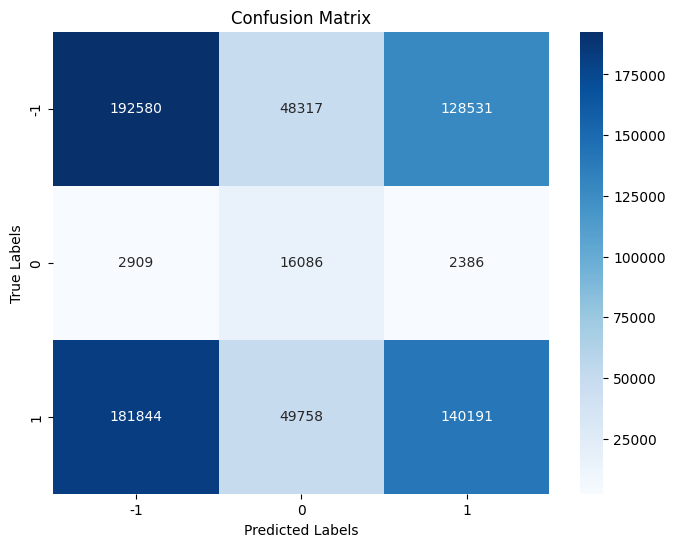

In [ ]:
# Define features and target
features = ['open_diff', 'high_diff', 'low_diff', 'close_diff', 'volume', 'was_missing', 'direction_t-1']
target = 'direction_t+1'
X = df_1m[features]
y = df_1m[target]

# Normalize features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=210)

# Train a Random Forest classifier
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=210, class_weight="balanced")
rf_model.fit(X_train, y_train)

# Evaluate the model
y_pred = rf_model.predict(X_test)
accuracy = rf_model.score(X_test, y_test)
print(f"Test Accuracy: {accuracy}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=["-1", "0", "1"]))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["-1", "0", "1"], yticklabels=["-1", "0", "1"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

### 1-hour interval direction prediction

Test Accuracy: 0.5411487018095987
Confusion Matrix:
[[3270 2994]
 [2838 3608]]
Classification Report:
              precision    recall  f1-score   support

          -1       0.54      0.52      0.53      6264
           1       0.55      0.56      0.55      6446

    accuracy                           0.54     12710
   macro avg       0.54      0.54      0.54     12710
weighted avg       0.54      0.54      0.54     12710



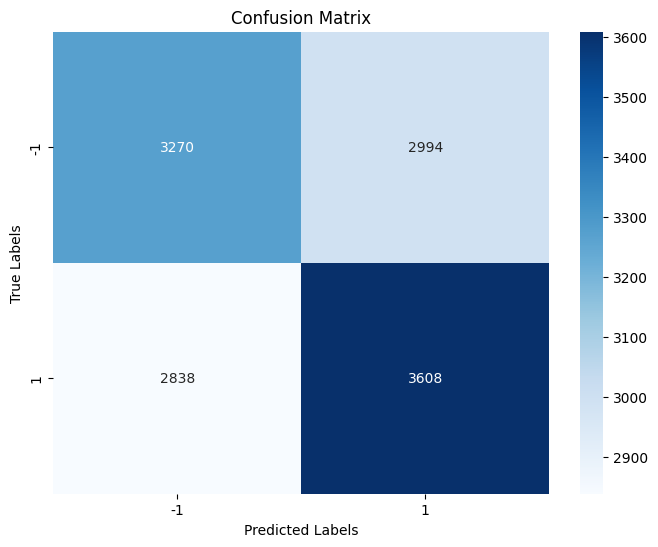

In [68]:
# Define features and target
features = ['open_diff', 'high_diff', 'low_diff', 'close_diff', 'volume', 'was_missing', 'direction_t-1']
target = 'direction_t+1'
X = df_1h[features]
y = df_1h[target]

# Normalize features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Map target to binary
y_binary = (y + 1) // 2

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_binary, test_size=0.2, random_state=210)

# Train a Random Forest classifier
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=210, class_weight="balanced")
rf_model.fit(X_train, y_train)

# Evaluate the model
y_pred = rf_model.predict(X_test)
accuracy = rf_model.score(X_test, y_test)
print(f"Test Accuracy: {accuracy}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=["-1", "1"]))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["-1", "1"], yticklabels=["-1", "1"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

### 1-day interval direction prediction

Test Accuracy: 0.49056603773584906
Confusion Matrix:
[[138 122]
 [148 122]]
Classification Report:
              precision    recall  f1-score   support

          -1       0.48      0.53      0.51       260
           1       0.50      0.45      0.47       270

    accuracy                           0.49       530
   macro avg       0.49      0.49      0.49       530
weighted avg       0.49      0.49      0.49       530



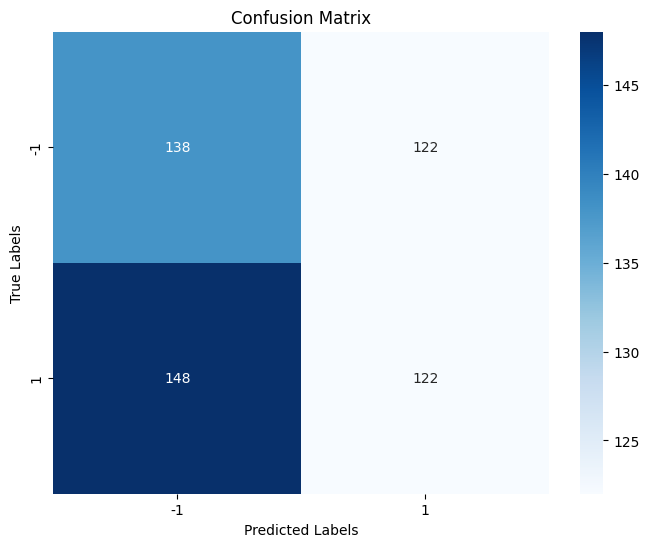

In [69]:
# Define features and target
features = ['open_diff', 'high_diff', 'low_diff', 'close_diff', 'volume', 'direction_t-1']
target = 'direction_t+1'
X = df_1d[features]
y = df_1d[target]

# Normalize features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Map target to binary
y_binary = (y + 1) // 2

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_binary, test_size=0.2, random_state=210)

# Train a Random Forest classifier
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=210, class_weight="balanced")
rf_model.fit(X_train, y_train)

# Evaluate the model
y_pred = rf_model.predict(X_test)
accuracy = rf_model.score(X_test, y_test)
print(f"Test Accuracy: {accuracy}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=["-1", "1"]))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["-1", "1"], yticklabels=["-1", "1"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# XGB

## XGB Directional Model

### 1-minute interval direction prediction

Test Accuracy: 0.529382299023606
Confusion Matrix:
[[249957 140852]
 [218042 153751]]
Classification Report:
              precision    recall  f1-score   support

          -1       0.53      0.64      0.58    390809
           1       0.52      0.41      0.46    371793

    accuracy                           0.53    762602
   macro avg       0.53      0.53      0.52    762602
weighted avg       0.53      0.53      0.52    762602



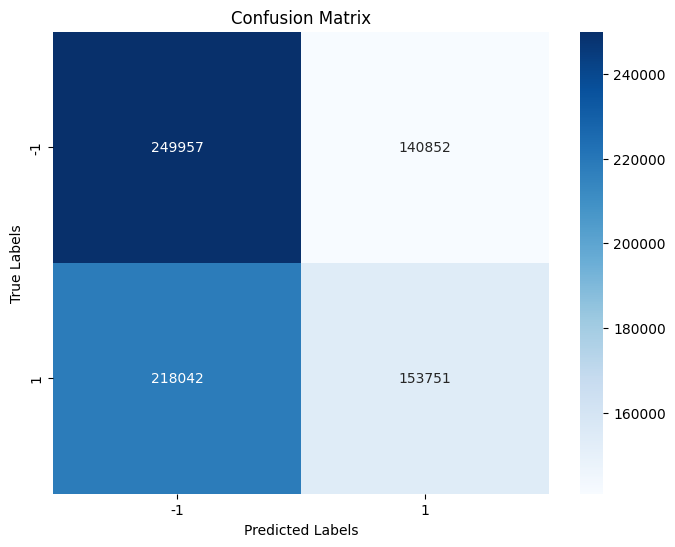

<Figure size 1000x800 with 0 Axes>

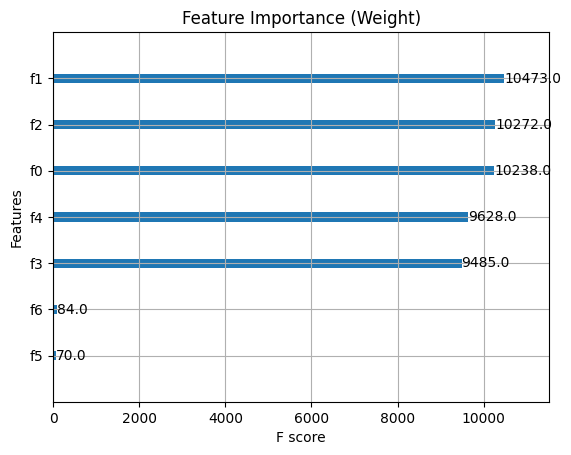

<Figure size 1000x800 with 0 Axes>

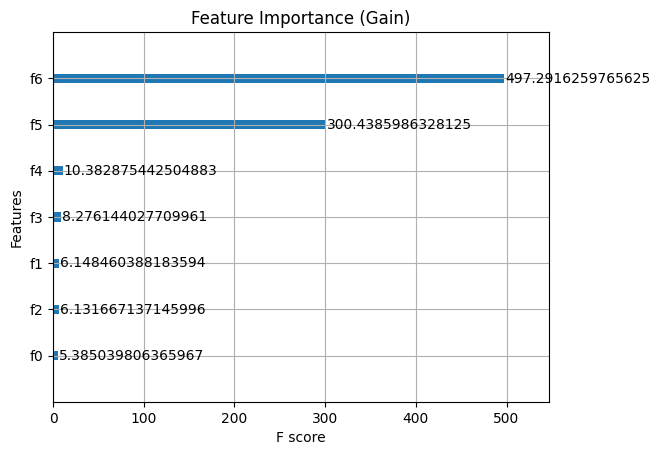

['../model/XGBoost/Directional_Classification_Model/xgb_direction_model_1m.pkl']

In [70]:
# Define features and target
features = ['open_diff', 'high_diff', 'low_diff', 'close_diff', 'volume', 'was_missing', 'direction_t-1']
target = 'direction_t+1'
X = df_1m[features]
y = df_1m[target]

# Normalize features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Map target to binary
y_binary = (y + 1) // 2  # Map -1 to 0, 1 stays as 1

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_binary, test_size=0.2, random_state=210)

# Train an XGBoost classifier
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=10,
    learning_rate=0.1,
    random_state=210,
    scale_pos_weight=1 
)
xgb_model.fit(X_train, y_train)

# Evaluate the model
y_pred = xgb_model.predict(X_test)
accuracy = xgb_model.score(X_test, y_test)
print(f"Test Accuracy: {accuracy}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=["-1", "1"]))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["-1", "1"], yticklabels=["-1", "1"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Visualize feature importance
plt.figure(figsize=(10, 8))
xgb.plot_importance(xgb_model, importance_type='weight')
plt.title('Feature Importance (Weight)')
plt.show()

plt.figure(figsize=(10, 8))
xgb.plot_importance(xgb_model, importance_type='gain')
plt.title('Feature Importance (Gain)')
plt.show()

# Save the model
joblib.dump(xgb_model, '../model/XGBoost/Directional_Classification_Model/xgb_direction_model_1m.pkl')

### 1-hour interval direction prediction

Test Accuracy: 0.5298190401258851
Confusion Matrix:
[[3065 3199]
 [2777 3669]]
Classification Report:
              precision    recall  f1-score   support

          -1       0.52      0.49      0.51      6264
           1       0.53      0.57      0.55      6446

    accuracy                           0.53     12710
   macro avg       0.53      0.53      0.53     12710
weighted avg       0.53      0.53      0.53     12710



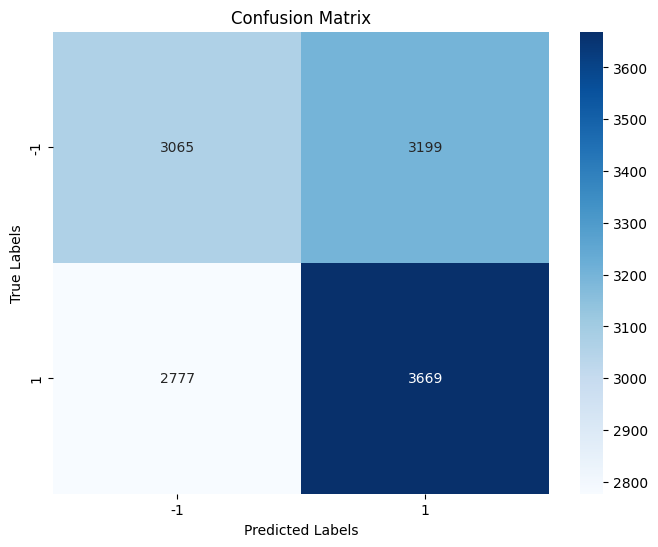

<Figure size 1000x800 with 0 Axes>

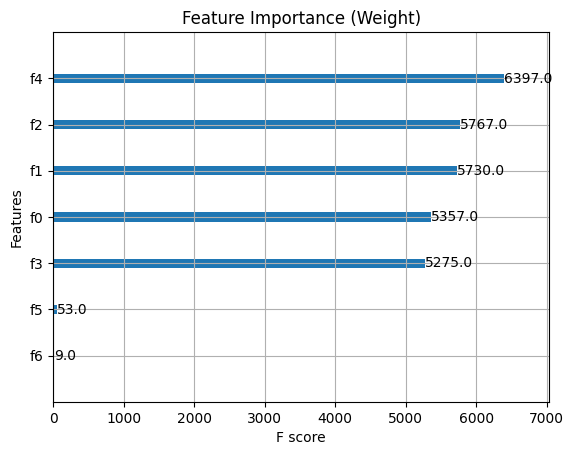

<Figure size 1000x800 with 0 Axes>

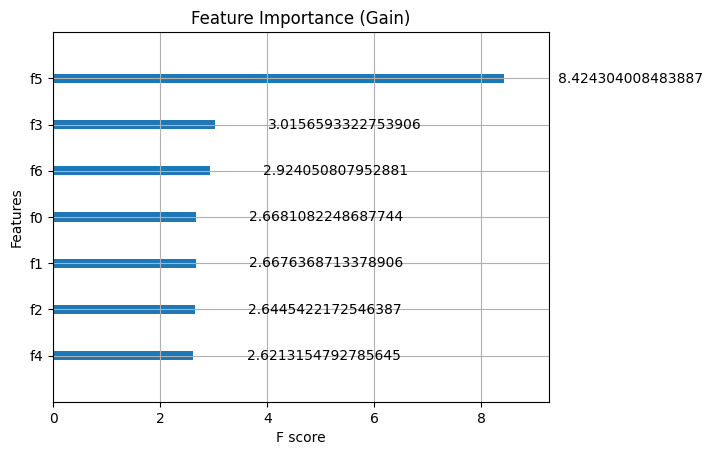

['../model/XGBoost/Directional_Classification_Model/xgb_direction_model_1h.pkl']

In [71]:
# Define features and target
features = ['open_diff', 'high_diff', 'low_diff', 'close_diff', 'volume', 'was_missing', 'direction_t-1']
target = 'direction_t+1'
X = df_1h[features]
y = df_1h[target]

# Normalize features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Map target to binary
y_binary = (y + 1) // 2  # Map -1 to 0, 1 stays as 1

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_binary, test_size=0.2, random_state=210)

# Train an XGBoost classifier
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=10,
    learning_rate=0.1,
    random_state=210,
    scale_pos_weight=1 
)
xgb_model.fit(X_train, y_train)

# Evaluate the model
y_pred = xgb_model.predict(X_test)
accuracy = xgb_model.score(X_test, y_test)
print(f"Test Accuracy: {accuracy}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=["-1", "1"]))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["-1", "1"], yticklabels=["-1", "1"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Visualize feature importance
plt.figure(figsize=(10, 8))
xgb.plot_importance(xgb_model, importance_type='weight')
plt.title('Feature Importance (Weight)')
plt.show()

plt.figure(figsize=(10, 8))
xgb.plot_importance(xgb_model, importance_type='gain')
plt.title('Feature Importance (Gain)')
plt.show()

# Save the model
joblib.dump(xgb_model, '../model/XGBoost/Directional_Classification_Model/xgb_direction_model_1h.pkl')

### 1-day interval direction prediction

Test Accuracy: 0.5037735849056604
Confusion Matrix:
[[125 135]
 [128 142]]
Classification Report:
              precision    recall  f1-score   support

          -1       0.49      0.48      0.49       260
           1       0.51      0.53      0.52       270

    accuracy                           0.50       530
   macro avg       0.50      0.50      0.50       530
weighted avg       0.50      0.50      0.50       530



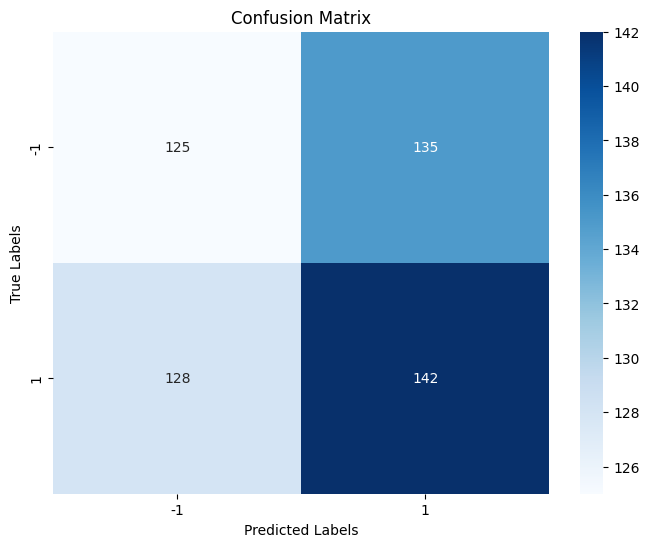

<Figure size 1000x800 with 0 Axes>

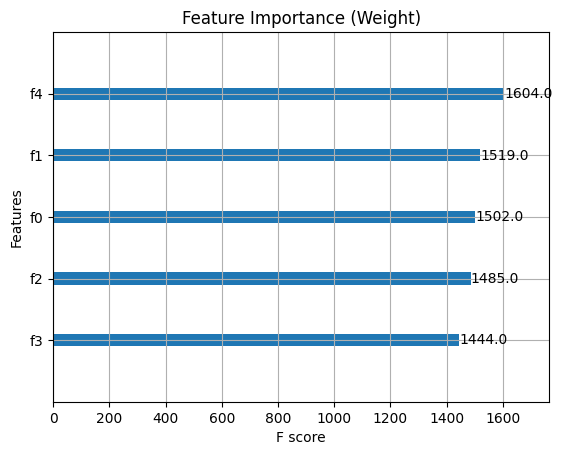

<Figure size 1000x800 with 0 Axes>

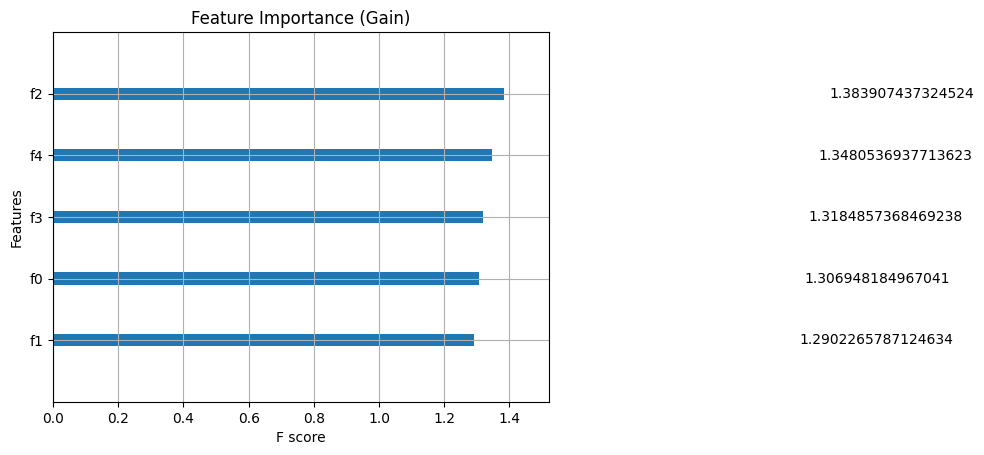

['../model/XGBoost/Directional_Classification_Model/xgb_direction_model_1d.pkl']

In [72]:
# Define features and target
features = ['open_diff', 'high_diff', 'low_diff', 'close_diff', 'volume', 'direction_t-1']
target = 'direction_t+1'
X = df_1d[features]
y = df_1d[target]

# Normalize features
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Map target to binary
y_binary = (y + 1) // 2  # Map -1 to 0, 1 stays as 1

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_binary, test_size=0.2, random_state=210)

# Train an XGBoost classifier
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=10,
    learning_rate=0.1,
    random_state=210,
    scale_pos_weight=1 
)
xgb_model.fit(X_train, y_train)

# Evaluate the model
y_pred = xgb_model.predict(X_test)
accuracy = xgb_model.score(X_test, y_test)
print(f"Test Accuracy: {accuracy}")

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=["-1", "1"]))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["-1", "1"], yticklabels=["-1", "1"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Visualize feature importance
plt.figure(figsize=(10, 8))
xgb.plot_importance(xgb_model, importance_type='weight')
plt.title('Feature Importance (Weight)')
plt.show()

plt.figure(figsize=(10, 8))
xgb.plot_importance(xgb_model, importance_type='gain')
plt.title('Feature Importance (Gain)')
plt.show()

# Save the model
joblib.dump(xgb_model, '../model/XGBoost/Directional_Classification_Model/xgb_direction_model_1d.pkl')